In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.chdir('..')

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
from src.models.exif_sc import EXIF_SC
import torch
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from src.datasets import (
    RealisticTamperingDataset,
    ColumbiaDataset,
    InTheWildDataset,
    SceneCompletionDataset
)
import random
from src.structures import PatchedImage

In [5]:
model = EXIF_SC("artifacts/exif_sc.npy", device="cuda:0")

In [13]:
ds = InTheWildDataset()
# idx = random.randint(0, len(ds)-1)
idx = 91
data = ds[idx]
img = data['img']
gt_map = data['map']

In [17]:
img = PatchedImage(img, 128, 30)

In [44]:
for batch in img.patch_maps_gen():
    maps = batch
    break

In [45]:
maps.shape

torch.Size([32, 713, 713])

In [46]:
gt_map.shape

(713, 713)

In [22]:
maps.dtype, gt_map.dtype

(torch.uint8, dtype('uint8'))

In [47]:
gt_map.mean()

0.3483335923315544

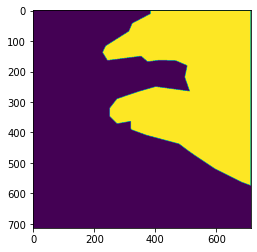

In [48]:
plt.imshow(gt_map)

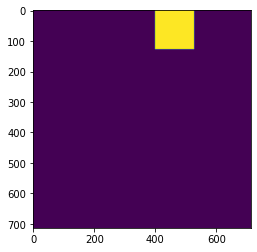

In [51]:
plt.imshow(maps[21])

In [6]:
shapes = []
for i in range(len(ds)):
    data = ds[i]
    shapes.append(list(data['img'].shape))

In [7]:
np.array(shapes)[:,1].mean()

1077.0298507462687

In [8]:
np.array(shapes)[:,2].mean()

1435.6119402985075

In [73]:
data['label']

1

In [74]:
img.shape

torch.Size([3, 533, 800])

In [75]:
# img_cv = cv2.imread("data/demo.png")[:, :, [2, 1, 0]]  # [H, W, C]
# img = torch.from_numpy(img_cv).permute(2, 0, 1)  # [C, H, W]

In [12]:
model.max_h_idx, model.max_w_idx

(31, 31)

In [13]:
(31 * 31) % 32

1

In [22]:
start = time.time()
pred = model.predict(img)
end = time.time()
print(end - start)

69.14436888694763


In [77]:
pred['ms'].min(), pred['ms'].max()

(0.0017701387, 0.40574574)

In [78]:
pred['score'].mean()

0.08683856

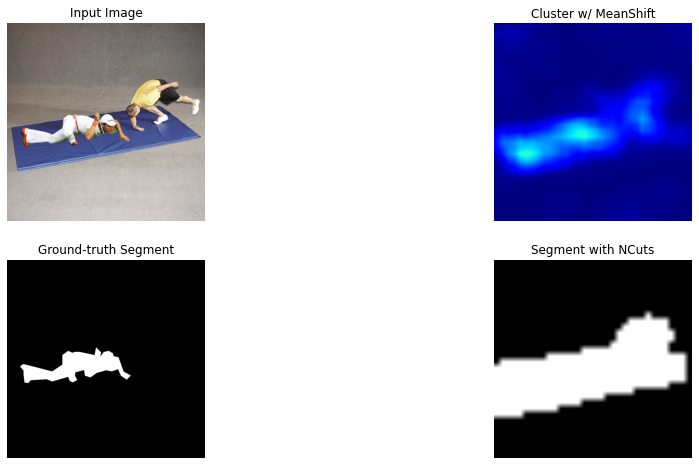

In [23]:
img_cv = img.permute(1, 2, 0)

plt.subplots(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.title('Input Image')
plt.imshow(img_cv)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Cluster w/ MeanShift')
plt.axis('off')
plt.imshow(pred['ms'], cmap='jet', vmin=0.0, vmax=1.0)

plt.subplot(2, 2, 3)
plt.title('Ground-truth Segment')
plt.axis('off')
plt.imshow(data['map'], vmin=0.0, vmax=1.0, cmap="gray")

plt.subplot(2, 2, 4)
plt.title('Segment with NCuts')
plt.axis('off')
plt.imshow(pred['ncuts'], vmin=0.0, vmax=1.0, cmap="gray")

plt.show()

# ANALYZE

In [6]:
model._init_img(img)

In [7]:
model.max_h_idx, model.max_w_idx

(31, 22)

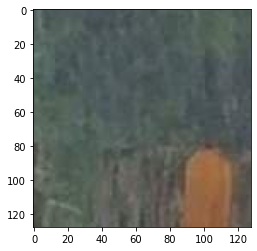

In [43]:
patch = model._get_patch(1, 9)
# patch = model.img
patch = patch.cpu().permute(1, 2, 0).numpy()

patch = (patch + 1) /2

# patch = patch.astype(int)
plt.imshow(patch)

In [39]:
patch_b = model._get_patch(16, 4)
# patch_b = model._get_patch(16, 4)
patches = next(model._patches_gen(682))

In [44]:
patch_b

tensor([[[-0.5608, -0.5216, -0.3176,  ..., -0.4275, -0.3647, -0.4118],
         [-0.5373, -0.5059, -0.3569,  ..., -0.4588, -0.4118, -0.4588],
         [-0.5137, -0.4745, -0.3647,  ..., -0.5059, -0.4824, -0.4745],
         ...,
         [ 0.2549,  0.3490,  0.3725,  ..., -0.4980, -0.5451, -0.4353],
         [ 0.1686,  0.3333,  0.3647,  ..., -0.5137, -0.6392, -0.5529],
         [ 0.0824,  0.2941,  0.3569,  ..., -0.5137, -0.6627, -0.6000]],

        [[-0.5294, -0.4431, -0.2078,  ..., -0.2863, -0.2235, -0.2706],
         [-0.5137, -0.4275, -0.2392,  ..., -0.3098, -0.2627, -0.3098],
         [-0.4745, -0.3882, -0.2471,  ..., -0.3333, -0.3098, -0.3255],
         ...,
         [-0.0824,  0.0118, -0.0039,  ..., -0.1765, -0.2235, -0.1137],
         [-0.1686,  0.0039,  0.0196,  ..., -0.2157, -0.3412, -0.2549],
         [-0.2471, -0.0118,  0.0275,  ..., -0.2314, -0.3804, -0.3020]],

        [[-0.6392, -0.5137, -0.1843,  ..., -0.1922, -0.1294, -0.1608],
         [-0.6000, -0.4902, -0.2157,  ..., -0

In [48]:
patch_b.min(), patch_b.max()

(tensor(-1., device='cuda:1'), tensor(1., device='cuda:1'))

In [46]:
patch_a.min(), patch_a.max()

(tensor(-0.4118, device='cuda:1'), tensor(0.3176, device='cuda:1'))

In [27]:
with torch.no_grad():
    pred = model.net.predict(patch_a, patch_b)
pred

tensor([0.9998], device='cuda:1')

In [40]:
preds = torch.zeros(682)

for i, patch_a in enumerate(patches):
    with torch.no_grad():
        preds[i] = model.net.predict(patch_a, patch_b)

In [41]:
preds.min(), preds.max()

(tensor(0.), tensor(0.))

# EVALUATION

In [28]:
import numpy as np
from src.datasets import RealisticTamperingDataset
from sklearn.metrics import average_precision_score
from pathlib import Path
from src.evaluators import Evaluator

In [23]:
save_path = Path("artifacts/predictions")
ds = ColumbiaDataset()

In [24]:
scores = np.load(save_path / "scores.npy")
score_maps = np.load(save_path / "score_maps.npy")
# ncuts = np.load(save_path / "rt_ncuts.npy")

In [26]:
score_maps.shape

(363, 768, 1152)

In [27]:
resize = (768, 1152)
labels = []
label_maps = []

for i in range(len(ds)):
    data = ds[i]
    data["map"] = cv2.resize(
        data["map"], resize, interpolation=cv2.INTER_LINEAR
    )
    labels.append(data['label'])
    label_maps.append(data['map'])

labels = np.array(labels)
label_maps = np.stack(label_maps, axis=0)

In [29]:
evaluator = Evaluator(model, ds)

In [33]:
metrics = evaluator._compute_localization_metrics(label_maps, score_maps)

In [34]:
evaluator.metrics

{'IoU-spliced': 0.17097105085849762,
 'IoU-non-spliced': 0.9050241112709045,
 'IoU': 0.5379975810647011}